# PROPHET

In [2]:
!pip install prophet

  Using cached cmdstanpy-1.2.5-py3-none-any.whl.metadata (4.0 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached stanio-0.5.1-py3-none-any.whl.metadata (1.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 46.0 MB/s eta 0:00:000:00:01
Using cached cmdstanpy-1.2.5-py3-none-any.whl (94 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 903.1/903.1 kB 31.9 MB/s eta 0:00:00
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Using cached stanio-0.5.1-py3-none-any.whl (8.1 kB)


In [22]:
# ======================
# 1. IMPORTS
# ======================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet

In [23]:
# ======================
# 2. LOAD AND PREPARE DATA
# ======================

# Load your dataset
df = pd.read_csv('../raw_data/all_clean_weather_1984_2024_filtered.csv', parse_dates=['DATE'])  # <-- Update your path if needed

# Rename columns
df.rename(columns={
    'TX': 'max_temperature',
    'TM': 'avg_temperature',
    'TN': 'min_temperature',
    'NOM_USUEL': 'location',
    'LAT': 'lat',
    'LON': 'lon',
    'DATE': 'DATE',
    'RR': 'amount_precipitation',
    'Co2 Mole fraction (ppm)': 'co2',
    'Methane ppm': 'ch4'
}, inplace=True)

# First replace ',' by '.' then convert to float
df['co2'] = df['co2'].str.replace(',', '.').astype(float)
df['ch4'] = df['ch4'].str.replace(',', '.').astype(float)

# Extract year and month
df['year'] = df['DATE'].dt.year
df['month'] = df['DATE'].dt.month

In [24]:
# ======================
# 3. AGGREGATE DATA
# ======================

# Group by national monthly average
monthly_avg = df.groupby(['year', 'month']).agg({
    'avg_temperature': 'mean',
    'co2': 'mean',
    'ch4': 'mean',
    'amount_precipitation': 'mean'
}).reset_index()

# Build a datetime column
monthly_avg['ds'] = pd.to_datetime(monthly_avg['year'].astype(str) + '-' + monthly_avg['month'].astype(str) + '-01')
monthly_avg['y'] = monthly_avg['avg_temperature']

# Only needed columns
prophet_df = monthly_avg[['ds', 'y', 'co2', 'ch4', 'amount_precipitation']]



In [25]:
# ======================
# 4. TRAIN PROPHET MODEL
# ======================

model = Prophet(
    yearly_seasonality=True,  # Yearly cycle ON
    daily_seasonality=False,  # No daily seasonality
    weekly_seasonality=False,  # No weekly seasonality
    seasonality_mode='additive',  # You can try 'multiplicative' if you want
)

# Add external regressors
model.add_regressor('co2')
model.add_regressor('ch4')
model.add_regressor('amount_precipitation')

model.fit(prophet_df)

01:43:35 - cmdstanpy - INFO - Chain [1] start processing
01:43:35 - cmdstanpy - INFO - Chain [1] done processing


In [26]:
# ======================
# 5. BUILD FUTURE DATAFRAME WITH FUTURE CO₂ AND CH₄
# ======================

# Create future months
future = model.make_future_dataframe(periods=20*12, freq='MS')

# Extract year and month
future['year'] = future['ds'].dt.year
future['month'] = future['ds'].dt.month

# Build CO2 and CH4 future trends
co2_trend = df.groupby('year')['co2'].mean().reset_index()
ch4_trend = df.groupby('year')['ch4'].mean().reset_index()

co2_slope, co2_intercept = np.polyfit(co2_trend['year'], co2_trend['co2'], 1)
ch4_slope, ch4_intercept = np.polyfit(ch4_trend['year'], ch4_trend['ch4'], 1)

future['co2'] = co2_intercept + co2_slope * future['year']
future['ch4'] = ch4_intercept + ch4_slope * future['year']

# Build rainfall future trend (OPTION 1 = assume constant mean)
rainfall_mean = df['amount_precipitation'].mean()
future['amount_precipitation'] = rainfall_mean  # Assume average future rainfall


In [27]:
# ======================
# 5. FUTURE PREDICTION
# ======================

# Predict future
forecast = model.predict(future)

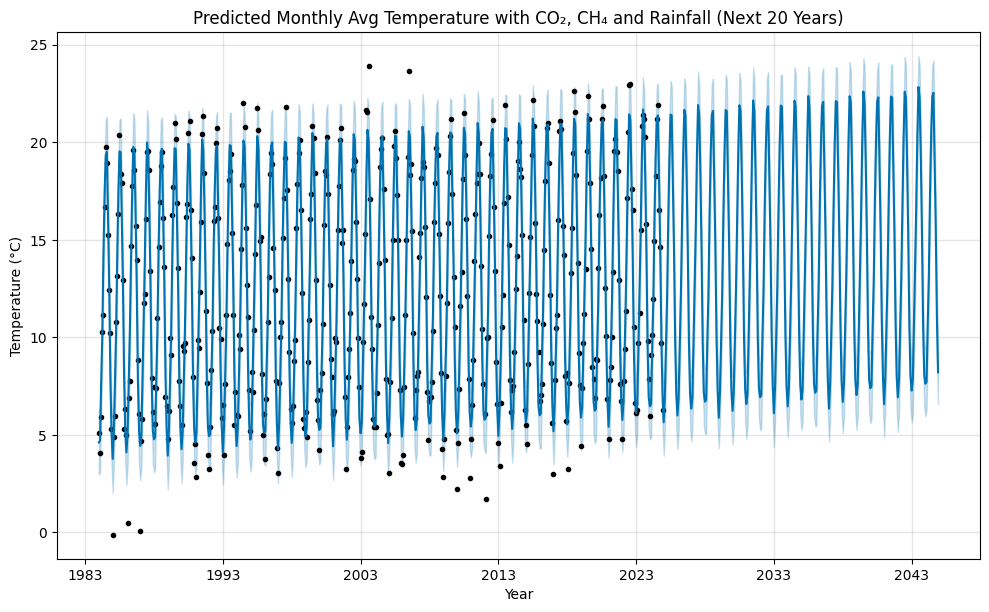

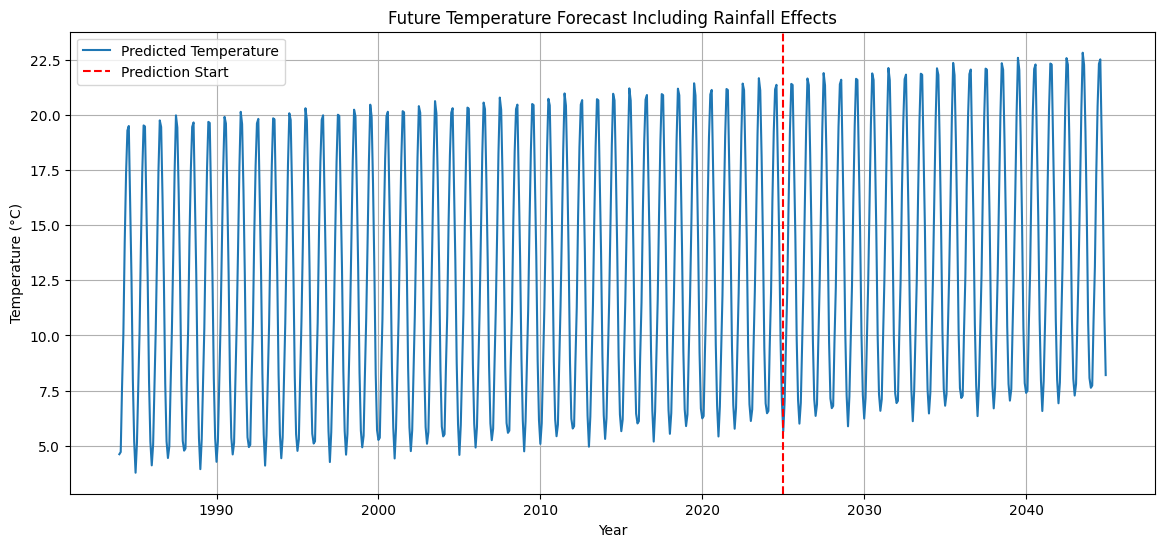

In [28]:
# ======================
# 6. PLOT RESULTS
# ======================
fig = model.plot(forecast)
plt.title("Predicted Monthly Avg Temperature with CO₂, CH₄ and Rainfall (Next 20 Years)")
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.show()

# Zoomed plot
plt.figure(figsize=(14,6))
plt.plot(forecast['ds'], forecast['yhat'], label='Predicted Temperature')
plt.axvline(x=pd.to_datetime('2025-01-01'), color='red', linestyle='--', label='Prediction Start')
plt.title("Future Temperature Forecast Including Rainfall Effects")
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()